UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


In [1]:
%%time
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

bucket='sagemaker-leafit-2' # customize to your bucket

containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/image-classification:latest'}
training_image = containers[boto3.Session().region_name]
print(training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest
CPU times: user 812 ms, sys: 180 ms, total: 992 ms
Wall time: 11.3 s


In [2]:
# Training the Image classification model

import os
import urllib.request
import boto3

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

        
def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)


# fmd data

download('./fmd_train.rec')
download('./fmd_val.rec')
upload_to_s3('validation/fmd', 'fmd_val.rec')
upload_to_s3('train/fmd', 'fmd_train.rec')

In [3]:
# Training parameters¶

# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 50 layers
num_layers = 44
# we need to specify the input image shape for the training data
image_shape = "3,240,180"
# we also need to specify the number of training samples in the training set
# for CIFAR-10 it is 50000
num_training_samples = 50
# specify the number of output classes
num_classes = 7
# batch size for training
mini_batch_size =  4
# number of epochs
epochs = 50
# optimizer
optimizer='adam'
# learning rate
learning_rate = 0.1
# Since we are using transfer learning, we set use_pretrained_model to 1 so that weights can be 
# initialized with pre-trained weights
use_pretrained_model = 0

In [6]:
%%time
import time
import boto3
from time import gmtime, strftime

# Training
# Run the training using Amazon sagemaker CreateTrainingJob API

s3 = boto3.client('s3')
# create unique job name 
job_name_prefix = 'sagemaker-imageclassification-fmd-2'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "optimizer":optimizer,
        "learning_rate": str(learning_rate),
        "use_pretrained_model": str(use_pretrained_model)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/train/fmd'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/validation/fmd'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: sagemaker-imageclassification-fmd-2-2018-10-10-12-26-13

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-leafit-2/train/fmd', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 5.31 ms


In [7]:

# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress
Training job ended with status: Completed


In [8]:

training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)

Training job ended with status: Completed


Maximum validation accuracy: 0.766854 


<Figure size 432x288 with 0 Axes>

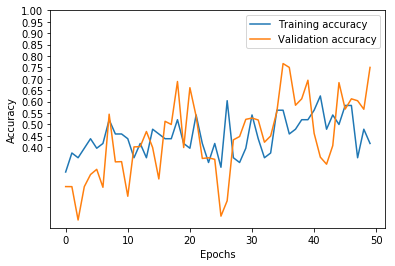

In [10]:
# Plot training and validation accuracies

import boto3
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

client = boto3.client('logs')

lgn='/aws/sagemaker/TrainingJobs'

# Update this with the actual name in CloudWatch logs
lsn=job_name+'/'+'algo-1-1539174575'

log=client.get_log_events(logGroupName=lgn, logStreamName=lsn)

trn_accs=[]
val_accs=[]
for e in log['events']:
  msg=e['message']
  if 'Validation-accuracy' in msg:
        val = msg.split("=")
        val = val[1]
        val_accs.append(float(val))
  if 'Train-accuracy' in msg:
        trn = msg.split("=")
        trn = trn[1]
        trn_accs.append(float(trn))

print("Maximum validation accuracy: %f " % max(val_accs))   
plt.clf()
fig, ax = plt.subplots()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
trn_plot, = ax.plot(range(epochs), trn_accs, label="Training accuracy")
val_plot, = ax.plot(range(epochs), val_accs, label="Validation accuracy")
plt.legend(handles=[trn_plot,val_plot])
ax.yaxis.set_ticks(np.arange(0.4, 1.05, 0.05))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
plt.show()

In [11]:
%%time
import boto3
from time import gmtime, strftime

# Inference
# Create Model

sage = boto3.Session().client(service_name='sagemaker') 

model_name="test-image-classification-model-fmd-10epochs"
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/image-classification:latest'}
hosting_image = containers[boto3.Session().region_name]
primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

test-image-classification-model-fmd-10epochs
s3://sagemaker-leafit-2/sagemaker-imageclassification-fmd-2/output/sagemaker-imageclassification-fmd-2-2018-10-10-12-26-13/output/model.tar.gz
arn:aws:sagemaker:us-east-1:892263410771:model/test-image-classification-model-fmd-10epochs
CPU times: user 36 ms, sys: 8 ms, total: 44 ms
Wall time: 406 ms


In [12]:
# Create Endpoint Configuration

from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: sagemaker-imageclassification-fmd-2-epc--2018-10-10-12-38-44
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:892263410771:endpoint-config/sagemaker-imageclassification-fmd-2-epc--2018-10-10-12-38-44


In [13]:
%%time
import time

# Create Endpoint 
# Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. 
# The end result is an endpoint that can be validated and incorporated into production applications. 
# This takes 9-11 minutes to complete.

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: sagemaker-imageclassification-fmd-2-ep--2018-10-10-12-39-30
EndpointArn = arn:aws:sagemaker:us-east-1:892263410771:endpoint/sagemaker-imageclassification-fmd-2-ep--2018-10-10-12-39-30
CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 269 ms


In [14]:
# Finally, now the endpoint can be created. It may take sometime to create the endpoint...

# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


In [18]:
# Perform Inference

import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker')

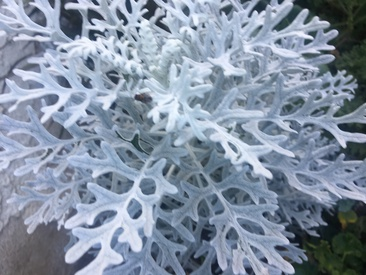

In [57]:
# Download test image

#!wget -O /tmp/test.jpg https://cdn.pixabay.com/photo/2015/09/29/10/14/truck-truck-963637_960_720.jpg
    
# file_name = './tmp/Rose_03.JPG'

# file_name = './tmp/MexicanOregano_01.JPG'
# file_name = './tmp/MexicanOregano_02.JPG'

# file_name = './tmp/Jade_01.JPG'
# file_name = './tmp/Jade_02.JPG'

# file_name = './tmp/CherryTomatoLeaf_01.JPG'
# file_name = './tmp/CherryTomatoLeaf_02.JPG'

# file_name = './tmp/LantanaFlame_01.JPG'
# file_name = './tmp/LantanaFlame_02.JPG'

file_name = './tmp/DustyMiller_02.JPG'



# test image
from IPython.display import Image

Image(file_name)

In [58]:
import json
import numpy as np


with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
print(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['Cherry Tomato Leaf', 'Dusty Miller', 'Jade', 'Lantana - Flame', 'Mexican Oregano', 'Red', 'Rose']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))


[9.922398021444678e-05, 0.5092715620994568, 0.09053678065538406, 0.00014387360715772957, 0.0044102743268013, 0.0015722514363005757, 0.39396604895591736]
Result: label - Dusty Miller, probability - 0.5092715620994568


In [ ]:
# Clean up
# When we're done with the endpoint, we can just delete it and the backing instances will be released. 
# Run the following cell to delete the endpoint.

print(endpoint_name)
sm = boto3.client('sagemaker')
sm.delete_endpoint_config(EndpointConfigName=endpoint_name)
sm.delete_endpoint(EndpointName=endpoint_name)
sm.delete_model(ModelName=endpoint_name)